In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

In [2]:
class TrialInterval:
    _startTimeSamples = 0
    _endTimeSamples = 0
    _isStartTimeRelToResponse = True
    _isEndTimeRelToResponse = True
    _averageLickDelay = 0.2 * 30000

    def __init__(self,start,end,startresp,endresp):
        self._startTimeSamples = start
        self._endTimeSamples = end
        self._isStartTimeRelToResponse = startresp
        self._isEndTimeRelToResponse = endresp

    def _CalculateAvgLickDelay(self,sessionfile):
        go_responses = np.array(sessionfile.trials.response)[sessionfile.trials.go]
        go_starts = np.array(sessionfile.trials.starts)[sessionfile.trials.go]
        self._averageLickDelay = np.nanmean(go_responses - go_starts)

    def _ToTimestamp(self,sessionfile,trial):
        starttime = sessionfile.trials.starts[trial]
        if self._isStartTimeRelToResponse:
            starttime = sessionfile.trials.response[trial]
            if np.isnan(starttime):
                starttime = sessionfile.trials.starts[trial] + self._averageLickDelay
        starttime = starttime + self._startTimeSamples

        endtime = sessionfile.trials.starts[trial]
        if self._isEndTimeRelToResponse:
            endtime = sessionfile.trials.response[trial]
            if np.isnan(endtime):
                endtime = sessionfile.trials.starts[trial] + self._averageLickDelay
        endtime = endtime + self._endTimeSamples

        return [starttime,endtime]

    def _ToString(self):
        return f"Interval has start {self._startTimeSamples}, end {self._startTimeSamples}. startresp {self._isStartTimeRelToResponse} and endresp {self._isEndTimeRelToResponse}"

# def statisticalComparison(sessionfile,clust,preCondition,postCondition):
#     preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
#     postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
#     allConditions = ilep.getAllConditions(sessionfile,clust)
#     preTrials = allConditions[preCondition].trials
#     postTrials = allConditions[postCondition].trials
        
#     preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
#     postTrialRates = np.full_like(postTrials,np.nan,dtype='float')    
#     for idx,trial in enumerate(preTrials):
#         start,end = preInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
#     for idx,trial in enumerate(postTrials):
#         start,end = postInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
#     pvalue_inc = mannwhitneyu(preTrialRates,postTrialRates,alternative='less').pvalue
#     pvalue_dec = mannwhitneyu(preTrialRates,postTrialRates,alternative='greater').pvalue
#     if pvalue_inc <= 0.05:# and np.median(postTrialRates) > np.median(preTrialRates):
#         label = 'increased'
#         pvalue = pvalue_inc
#     elif pvalue_dec <= 0.05:# and np.median(postTrialRates) < np.median(preTrialRates):
#         label = 'decreased'
#         pvalue = pvalue_dec
#     else:
#         label = 'unchanged'
#         pvalue = np.min(pvalue_inc,pvalue_dec)
#     return label,pvalue

def statisticalComparison(sessionfile,clust,preCondition,postCondition,preInterval,postInterval,iterations=5000,sample_percent=0.5,pthresh=0.95,modthresh=0.1):
    if pthresh < 0.5:
        raise Exception('pthresh cannot be less than 50%!')
    
    preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
    allConditions = ilep.getAllConditions(sessionfile,clust)
    preTrials = allConditions[preCondition].trials
    postTrials = allConditions[postCondition].trials
    
    if preCondition == postCondition:
        paired=True
    else:
        paired=False
    
    preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
    postTrialRates = np.full_like(postTrials,np.nan,dtype='float')
    
    for idx,trial in enumerate(preTrials):
        start,end = preInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
    for idx,trial in enumerate(postTrials):
        start,end = postInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
    
    increased=0
    decreased=0
    unchanged=0
    
    for i in range(iterations):
        if paired and len(preTrialRates) != len(preTrialRates):
            raise Exception('Non-equal length paired comparison')
        if paired:
            raise Exception('Paired comparison is not yet implemented')
        else:
            preIdxs = range(len(preTrialRates))
            postIdxs = range(len(postTrialRates))
            preIdxs = np.random.permutation(preIdxs)
            postIdxs = np.random.permutation(postIdxs)
            maxIdx = int(sample_percent*min(len(preIdxs),len(postIdxs)))
            preIdxs = preIdxs[range(maxIdx)]
            postIdxs = postIdxs[range(maxIdx)]
            
        preTrialsToCompare = preTrialRates[preIdxs]
        postTrialsToCompare = postTrialRates[postIdxs]
        
        deltaTrialMean = np.mean(postTrialsToCompare - preTrialsToCompare)
        
        if deltaTrialMean >= modthresh:
            increased+=1
        elif deltaTrialMean <= -modthresh:
            decreased+=1
        else:
            unchanged+=1
            
    p_increased = increased / (increased+decreased+unchanged)
    p_decreased = decreased / (increased+decreased+unchanged)
    p_unchanged = unchanged / (increased+decreased+unchanged)
    
    print(f"inc: {p_increased}, dec: {p_decreased}, unch: {p_unchanged}")
    
    if p_increased >= pthresh:
        label='increased'
        pval = 1-p_increased
    elif p_decreased >= pthresh:
        label='decreased'
        pval = 1-p_decreased
    elif p_unchanged >= pthresh:
        label='unchanged'
        pval = 1-p_unchanged
    else:
        label='inconclusive'
        pval=1-np.max([p_increased,p_decreased,p_unchanged])
    return label,pval

In [3]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [4]:
def get_response_times_with_default(sessionfile):
    response_times_in_trial = (sessionfile.trials.response-sessionfile.trials.starts)
    default_response_time = np.nanmedian(response_times_in_trial)

    response_times = sessionfile.trials.response
    nogo_trials = np.isnan(response_times)
    response_times[nogo_trials] = sessionfile.trials.starts[nogo_trials]+default_response_time
    return response_times

In [5]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Reviewer 2\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shou

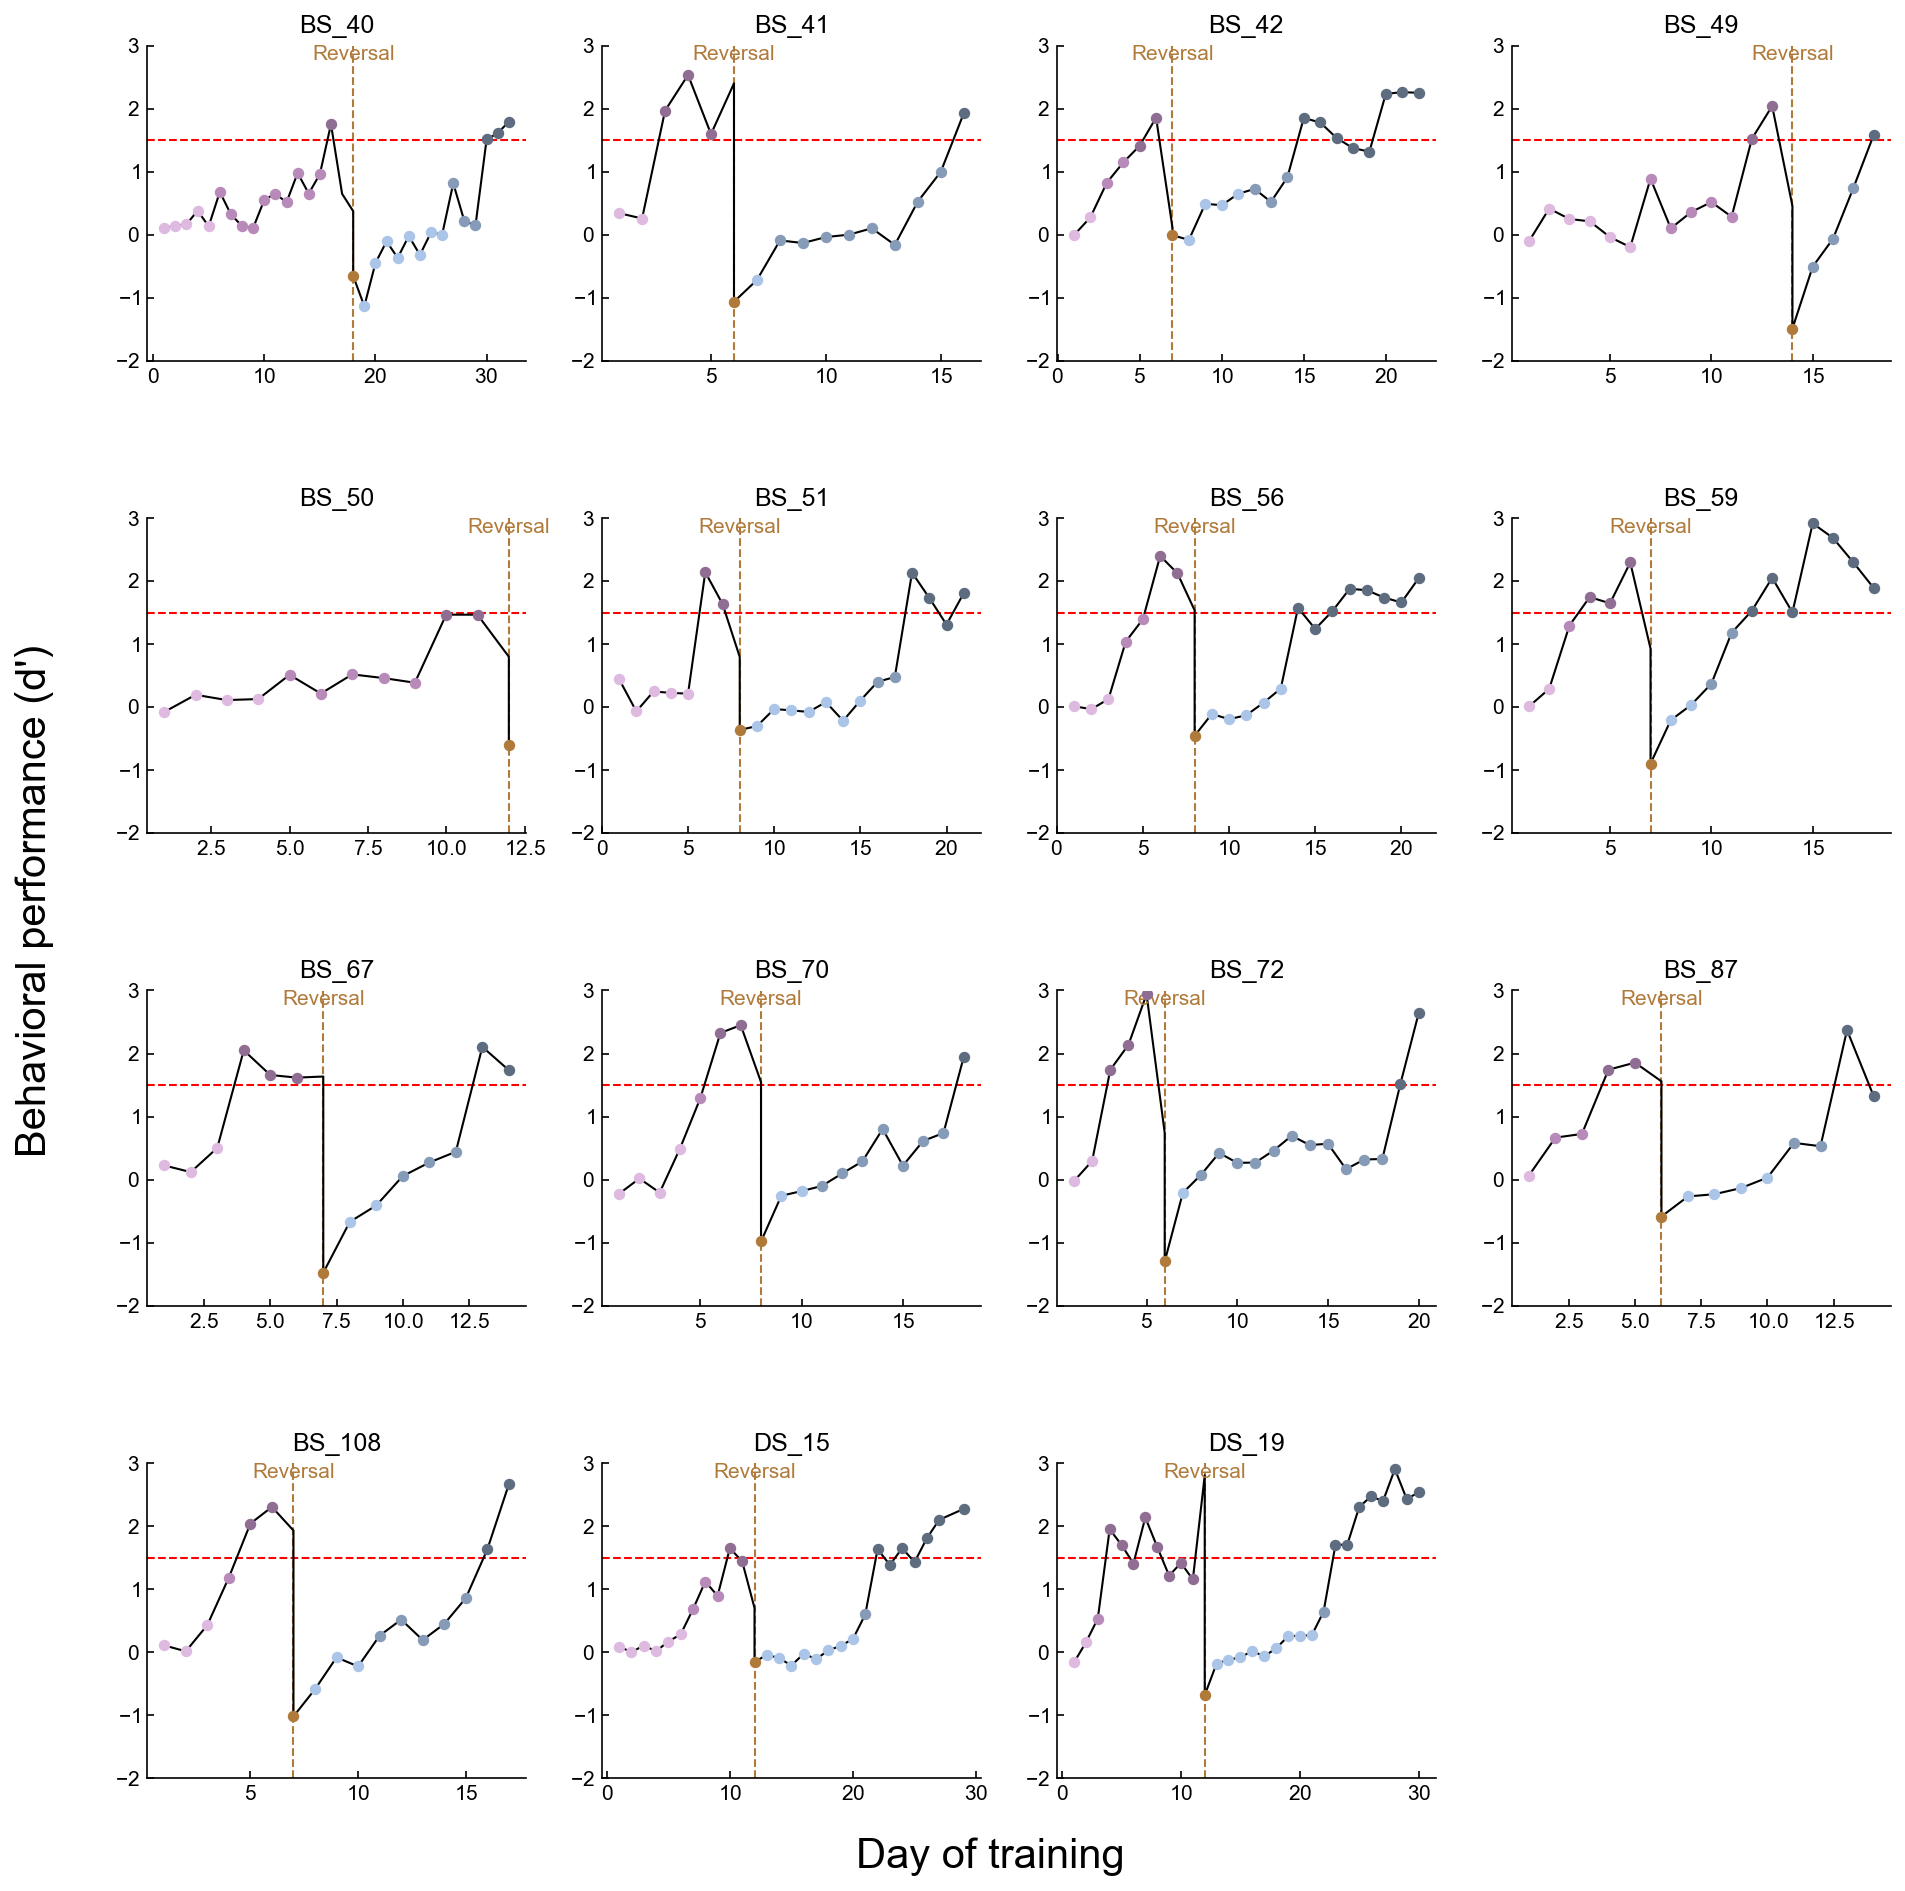

In [6]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(dualanimalnames,animalBehaviors,plot=True)

In [7]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task == 'passive no behavior':
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    
    if sessionfile.meta.animal not in dualanimalnames:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:31<00:00, 23.50it/s]


In [8]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
        raise e
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:45<00:00, 40.02it/s] 

errors for: []


# Folder Reset

In [9]:
### Reset raster directory
os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters'))
os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters','pngs'))
os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters','pdfs'))
for modcat in ['CR','NCR','Middle']:
    os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',modcat))
    os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',modcat,'pdfs'))
    os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',modcat,'pngs'))
    for phase in ['pre early','pre late','pre expert','switch','post early','post late','post expert']:
        os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',modcat,phase))
        os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',modcat,phase,'pdfs'))
        os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',modcat,phase,'pngs'))

# Plotting Code

In [10]:
def visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms=-250,Figure_end_time_ms=1000,xtickstouse=[0,500,1000],xticklabelstouse=None,align_to_choice=False,switch_cond='NA',limitToUse=None):
    buffer = 250
    sort_by_response_latency = False # Not implemented
    bw_scott_factor = 3
    
    if align_to_choice:
        mn = 0.8
        spread = 0.5
    else:
        mn = 3.5
        spread = 2
    
    condition_of_interest = 'ERROR'
    assert (sessionfile.meta.task not in ['switch','opto switch','tuning_switch','second switch']) or (switch_cond != 'NA')
    if align_to_choice:
        if sessionfile.meta.task in ['switch','opto switch','tuning_switch','second switch']:
            condition_of_interest = switch_cond+'_go'
        else:
            condition_of_interest = 'go'
    else:
        if sessionfile.meta.task in ['switch','opto switch','tuning_switch','second switch']:
            condition_of_interest = switch_cond
        else:
            condition_of_interest = 'all_trials'
    
    response_times = sessionfile.trials.response#get_response_times_with_default(sessionfile)
    ax2.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.tick_params(direction='out')
#     ax1.get_yaxis().set_visible(False)

    if align_to_choice:
        Y = sessionfile.responsiveness[clust][condition_of_interest].FRmodulation_choice
    else:
        Y = sessionfile.responsiveness[clust][condition_of_interest].FRmodulation
    if np.isnan(Y):
        color_to_use = 'k'
    else:
        color_to_use = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

    ### Get set of all trials to consider
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = allConditions[condition_of_interest].trials
    
    ### Reorder trials
    # Nogo then go
    trials_nogo = allConditions['miss'].trials
    trials_go = allConditions['hit'].trials
    trialsToPlot = np.concatenate((trials_nogo,trials_go))
    len_nogo = len(trials_nogo)
    len_go = len(trials_go)
#     # Just nogo
#     trialsToPlot = allConditions['nogo'].trials
    ### End trial reordering

    ### Extract spike times
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    trialStimTimes = []
    trialChoiceTimes = []
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        if align_to_choice:
            starttime = response_times[trial]+(Figure_start_time_ms-buffer)*sessionfile.meta.fs/1000
            endtime = response_times[trial]+(Figure_end_time_ms+buffer)*sessionfile.meta.fs/1000
        else:
            starttime = sessionfile.trials.starts[trial]+(Figure_start_time_ms-buffer)*sessionfile.meta.fs/1000
            endtime = sessionfile.trials.starts[trial]+(Figure_end_time_ms+buffer)*sessionfile.meta.fs/1000
        
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        if align_to_choice:
            this_trial_spikes = this_trial_spikes - response_times[trial]
        else:
            this_trial_spikes = this_trial_spikes - sessionfile.trials.starts[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        trialSpikes.append(this_trial_spikes)
        if align_to_choice:
            trialStimTimes.append(-(response_times[trial]-sessionfile.trials.starts[trial])/sessionfile.meta.fs*1000)
            trialChoiceTimes.append(0)
        else:
            trialStimTimes.append(0)
            trialChoiceTimes.append((response_times[trial]-sessionfile.trials.starts[trial])/sessionfile.meta.fs*1000)
    trialSpikes = np.array(trialSpikes,dtype='object')

    #Plot Raster
    #NOGO
    count = 0
    for idx,trial in enumerate(trials_nogo):
        if count < 15:
            X = trialSpikes[idx]
            Y = np.ones_like(trialSpikes[idx])*count
            mask = np.logical_and( np.greater(X,Figure_start_time_ms) , np.less(X,Figure_end_time_ms) )
            if np.sum(mask) > 0:
                X = X[mask]
                Y = Y[mask]
                this_trial_col = 'purple'
                ax1.scatter(X,Y,color=this_trial_col,s=9.,marker=2,lw=1.5,zorder=0,clip_on=False)
                count += 1
    #GO
    count = 0
    for idx,trial in enumerate(trials_go):
        if count < 15:
            X = trialSpikes[idx+len_nogo]
            Y = np.ones_like(trialSpikes[idx+len_nogo])*(count+15)
            mask = np.logical_and( np.greater(X,Figure_start_time_ms) , np.less(X,Figure_end_time_ms) )
            if np.sum(mask) > 0:
                X = X[mask]
                Y = Y[mask]
                this_trial_col = 'green'
                ax1.scatter(X,Y,color=this_trial_col,s=9.,marker=2,lw=1.5,zorder=0,clip_on=False)
                count += 1
    
    
    
    ### Plot stimulus times
    if align_to_choice:
        X = np.array(trialStimTimes)
        Y = np.array(range(len(trialsToPlot)))
        mask = np.less(Y,30)
        X = X[mask]
        Y = Y[mask]+0.5
        ax1.scatter(X,Y,marker='o',fc='k',ec='k',zorder=1,s=10,lw=2)#,clip_on=False)
#     ### Plot response times
#     if align_to_choice:
#         ax1.scatter(trialChoiceTimes,range(len(trialsToPlot)),marker='o',fc='g',ec='g',zorder=1,s=10,lw=0)

#     if EIL == 'switch':
#        try:
#            switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
#            ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
#        except:
#            pass
    
    #Legend
#     ax1.scatter([],[],marker='o',fc='k',ec='k',s=15,label='stimulus')
#     ax1.scatter([],[],marker='o',fc='g',ec='g',s=15,label='response')
#     lgd = ax1.legend(frameon=False,loc=(-0.25,1),ncol=2,fontsize=14)
    
    #Set trial limits
    max_trial_value = len(trialsToPlot)
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30])#,40,50,60,80,100,120,140,150,160,180,200])#,220,240,260,280,300,320,340,360,380,400])
    idx_of_okay_limits = np.less_equal(sequence_of_possible_axis_limits,max_trial_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    if not len(valid_limits) > 0:
        return False,[]
    limit = np.max(valid_limits)
    ax1.set_xlim([starttime,endtime])
    ax1.set_ylim([0,limit])
#     ax1.set_yticks([0,limit/2,limit])
#     ax1.set_ylabel('Trial')
    ax1.set_yticks([])



    
    #Plot PSTH
    starttime = Figure_start_time_ms
    endtime = Figure_end_time_ms
    xrange = np.linspace(starttime,endtime,num=1000)
    trialSpikes_nogo = trialSpikes[range(len_nogo)]
    numSplits = min(10,len(trialSpikes_nogo))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(_,train_index) in enumerate(kf.split(trialSpikes_nogo)):
        PSTHspikes = np.concatenate(trialSpikes_nogo[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = sem(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=2,color='purple')
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color='purple',alpha=0.1,zorder=-10,lw=0)


    
    #Plot PSTH
    starttime = Figure_start_time_ms
    endtime = Figure_end_time_ms
    xrange = np.linspace(starttime,endtime,num=1000)
    trialSpikes_go = trialSpikes[range(len_nogo,len_nogo+len_go)]
    numSplits = min(10,len(trialSpikes_go))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(_,train_index) in enumerate(kf.split(trialSpikes_go)):
        PSTHspikes = np.concatenate(trialSpikes_go[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = sem(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=2,color='green')
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color='green',alpha=0.1,zorder=-10,lw=0)







    
    #PSTH Limits
    if limitToUse is None:
        max_FR_value = np.max(avg_FR+sem_FR) * 1.1
        sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
        valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
        limit = np.min(valid_limits)
    else:
        limit  = limitToUse
    ###
#     limit = 30
    ###
    ax2.set_ylim([0,limit])
#     ax2.set_yticks([0,limit/2,limit])
#     ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_yticks([0,limit])
    ax2.set_yticklabels(['0',str(limit)])
    ylab = ax2.set_ylabel('')#Firing rate\n(spikes/s)')
    
    ### X limits
    ax1.set_xlim([starttime,endtime])
    ax2.set_xlim([starttime,endtime])
    ax1.set_xticks(np.array(xtickstouse))
    if xticklabelstouse is None:
        ax1.set_xticklabels(np.array(xtickstouse))#/1000)
    else:
        ax1.set_xticklabels(xticklabelstouse)#/1000)
    if align_to_choice:
        xlab = ax1.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to response (s)')
    else:
        xlab = ax1.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to stimulus (s)')
    ax2.set_xticks([])
    
    ### Tone bar
    if not align_to_choice:
        ax2.plot([0,100],[limit]*2,c='k',lw=2,clip_on=False,zorder=10)
        
    ### Stim bar
    if not align_to_choice:
        ax1.plot([0,0],[0,93],linestyle='--',lw=1,color='gray',zorder=-10,clip_on=False)
        ax2.plot([0,0],ax2.get_ylim(),linestyle='--',lw=1,color='gray',zorder=-10,clip_on=False)
    else:
        ax1.plot([0,0],[0,93],linestyle='--',lw=1,color='green',zorder=-10,clip_on=False)
#         ax2.plot([0,0],ax2.get_ylim(),linestyle='--',lw=1,color='green',zorder=-10,clip_on=False)
    
    ################################################################
    
    #font size 15 old style. Font size 35 new style
    
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.75)
        ax2.spines[axis].set_linewidth(1.75)
    ax1.tick_params(width=0)
    ax2.tick_params(width=1.75)
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
        ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(35)
    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
        ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(35)

    go_spikes = [np.sum(np.logical_and(np.greater(s,-50),np.less(s,0))) for s in trialSpikes_go]
    nogo_spikes = [np.sum(np.logical_and(np.greater(s,-50),np.less(s,0))) for s in trialSpikes_nogo]
    pval = ttest_ind(go_spikes,nogo_spikes).pvalue
    if pval <= 0.05:
        ax2.set_title('p = '+str(pval))
    
    artists = [ylab,xlab]
    return True,artists

# Stim Rasters

2it [00:00,  6.41it/s]

Fail
Fail


4it [00:00,  6.59it/s]

Fail
Fail


6it [00:00,  5.97it/s]

Fail
Fail


8it [00:01,  6.01it/s]

Fail
Fail


10it [00:01,  6.51it/s]

Fail
Fail
Skipping Switch


12it [00:01,  8.18it/s]

Skipping Switch
Skipping Switch
Skipping Switch


18it [00:02, 13.26it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


20it [00:02, 12.59it/s]

Skipping Switch
Skipping Switch
Skipping Switch


25it [00:02, 14.47it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


27it [00:02, 13.27it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


30it [00:03, 13.29it/s]

Skipping Switch
Skipping Switch
Skipping Switch


36it [00:03, 15.14it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


38it [00:03, 13.69it/s]

Skipping Switch
Skipping Switch
Skipping Switch


40it [00:03, 12.72it/s]

Skipping Switch
Skipping Switch


43it [00:05,  3.90it/s]

fail


44it [00:05,  3.97it/s]

fail


45it [00:06,  4.07it/s]

fail


47it [00:07,  2.41it/s]

Fail


50it [00:09,  2.40it/s]

fail
Fail


52it [00:10,  1.81it/s]

fail


54it [00:12,  1.71it/s]

fail


58it [00:16,  1.26it/s]

fail


59it [00:16,  1.61it/s]

fail


60it [00:16,  1.99it/s]

fail


62it [00:17,  1.77it/s]

fail


63it [00:18,  2.17it/s]

fail


65it [00:19,  1.81it/s]

fail


66it [00:19,  2.06it/s]

fail


67it [00:20,  2.46it/s]

fail


72it [00:26,  1.09it/s]

fail


75it [00:29,  1.09it/s]

fail


78it [00:32,  1.09it/s]

fail


79it [00:32,  1.35it/s]

fail


85it [00:38,  1.51it/s]

fail
fail


88it [00:40,  2.00it/s]

fail
fail


93it [00:44,  1.71it/s]

fail
Fail


95it [00:44,  2.81it/s]

Fail
Fail


96it [00:44,  3.44it/s]

Fail


98it [00:45,  3.71it/s]

fail
fail


99it [00:45,  4.34it/s]

Fail


104it [00:46,  4.86it/s]

Fail
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


107it [00:47,  7.59it/s]

Skipping Switch
Skipping Switch


112it [00:47, 10.00it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


115it [00:47, 12.73it/s]

Skipping Switch
Skipping Switch
Skipping Switch


121it [00:48, 13.43it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


124it [00:48, 15.62it/s]

Skipping Switch


132it [00:57,  1.35it/s]

fail


146it [01:15,  1.02it/s]

fail


155it [01:25,  1.01it/s]

fail


157it [01:27,  1.18it/s]

fail


161it [01:31,  1.21it/s]

fail


163it [01:33,  1.30it/s]

fail


168it [01:37,  1.44it/s]

fail
Fail


170it [01:38,  2.44it/s]

Fail
Fail


172it [01:38,  3.50it/s]

fail
fail


174it [01:38,  4.34it/s]

fail
fail


176it [01:40,  2.16it/s]

fail


179it [01:42,  2.11it/s]

fail
Fail


181it [01:42,  3.10it/s]

Fail
Fail


183it [01:42,  4.04it/s]

Fail
Fail


184it [01:42,  4.28it/s]

fail


187it [01:46,  1.55it/s]

fail


201it [02:04,  1.02s/it]

fail


208it [02:12,  1.01s/it]

fail


209it [02:13,  1.25it/s]

fail


211it [02:14,  1.41it/s]

fail


212it [02:15,  1.46it/s]

fail


213it [02:15,  1.83it/s]

fail


214it [02:15,  2.18it/s]

fail


215it [02:15,  2.60it/s]

fail


217it [02:17,  1.63it/s]

fail


221it [02:21,  1.19it/s]

fail


222it [02:22,  1.51it/s]

fail


231it [02:33,  1.01it/s]

fail


232it [02:33,  1.30it/s]

fail


235it [02:36,  1.21it/s]

fail


238it [02:39,  1.15it/s]

fail


244it [02:47,  1.01s/it]

fail


245it [02:47,  1.28it/s]

fail


246it [02:47,  1.63it/s]

fail


247it [02:47,  2.04it/s]

fail


250it [02:51,  1.39it/s]

fail


252it [02:52,  1.25it/s]

fail


254it [02:54,  1.42it/s]

fail


259it [02:59,  1.19it/s]

fail


263it [03:02,  1.53it/s]

fail
fail


265it [03:03,  2.38it/s]

fail
fail


266it [03:03,  1.93it/s]

fail


269it [03:06,  1.49it/s]

fail


275it [03:13,  1.00s/it]

fail


277it [03:15,  1.27it/s]

fail


278it [03:15,  1.59it/s]

fail


292it [03:33,  1.02s/it]

fail


296it [03:37,  1.33it/s]

fail
fail


297it [03:37,  1.66it/s]

fail


298it [03:37,  2.03it/s]

fail
fail


300it [03:38,  2.97it/s]

fail


302it [03:40,  1.51it/s]

PhaseFail Skipping


303it [03:40,  1.81it/s]

PhaseFail Skipping


304it [03:41,  2.02it/s]

PhaseFail Skipping


305it [03:41,  2.04it/s]

PhaseFail Skipping


306it [03:42,  2.35it/s]

fail


307it [03:42,  2.65it/s]

fail


308it [03:42,  2.97it/s]

fail


309it [03:43,  2.45it/s]

PhaseFail Skipping


310it [03:43,  2.68it/s]

PhaseFail Skipping


311it [03:43,  3.05it/s]

fail


312it [03:43,  3.16it/s]

PhaseFail Skipping


313it [03:44,  3.31it/s]

fail


315it [03:45,  2.46it/s]

Fail
fail


316it [03:45,  2.70it/s]

PhaseFail Skipping


319it [03:46,  4.20it/s]

fail
Skipping Switch
Skipping Switch


321it [03:46,  5.71it/s]

Skipping Switch
Skipping Switch
Skipping Switch


325it [03:46,  8.01it/s]

Skipping Switch
Skipping Switch
Skipping Switch


327it [03:47,  4.20it/s]

Skipping Switch
Skipping Switch
Skipping Switch


331it [03:47,  6.88it/s]

Skipping Switch
Skipping Switch
Skipping Switch


333it [03:48,  7.89it/s]

Skipping Switch
Skipping Switch
Skipping Switch


337it [03:48,  9.08it/s]

Skipping Switch
Skipping Switch
Skipping Switch


339it [03:49,  4.65it/s]

Skipping Switch
Skipping Switch
Skipping Switch


343it [03:49,  6.55it/s]

Skipping Switch
Skipping Switch
Skipping Switch


346it [03:50,  7.97it/s]

Skipping Switch
Skipping Switch
Skipping Switch


348it [03:50,  8.89it/s]

Skipping Switch
Skipping Switch


350it [03:51,  4.52it/s]

Skipping Switch
Skipping Switch
Skipping Switch


353it [03:51,  6.06it/s]

Skipping Switch
Skipping Switch
Skipping Switch


355it [03:51,  7.13it/s]

Skipping Switch


357it [03:53,  3.06it/s]

fail


359it [03:53,  3.56it/s]

fail
fail


360it [03:54,  2.25it/s]

fail


363it [03:56,  1.66it/s]

fail


365it [03:57,  2.50it/s]

fail
fail


368it [04:00,  1.27it/s]

fail


373it [04:06,  1.06s/it]

Fail


379it [04:14,  1.11s/it]

fail


381it [04:16,  1.07it/s]

fail


382it [04:16,  1.33it/s]

fail


383it [04:16,  1.67it/s]

fail


386it [04:20,  1.20it/s]

fail


387it [04:20,  1.54it/s]

fail


390it [04:24,  1.01it/s]

fail


398it [04:32,  1.33it/s]

Fail
Fail


402it [04:37,  1.08it/s]

Fail


406it [04:41,  1.09s/it]

Fail


408it [04:43,  1.17it/s]

fail


412it [04:48,  1.08s/it]

Fail


414it [04:49,  1.18it/s]

fail


415it [04:49,  1.49it/s]

fail


422it [04:58,  1.08it/s]

fail


424it [04:59,  1.30it/s]

fail


425it [04:59,  1.60it/s]

fail


426it [05:00,  1.95it/s]

fail


427it [05:01,  1.45it/s]

fail


429it [05:02,  1.55it/s]

fail


430it [05:02,  1.89it/s]

fail


431it [05:03,  2.25it/s]

fail


432it [05:03,  2.63it/s]

fail


433it [05:03,  2.93it/s]

fail


435it [05:05,  1.92it/s]

fail


436it [05:05,  2.32it/s]

fail


437it [05:05,  2.64it/s]

fail


440it [05:08,  1.91it/s]

fail
fail


444it [05:12,  1.30it/s]

fail


446it [05:13,  1.44it/s]

Fail


449it [05:16,  1.18it/s]

Fail


451it [05:18,  1.39it/s]

fail


456it [05:24,  1.11it/s]

fail


457it [05:24,  1.43it/s]

Fail


460it [05:26,  1.43it/s]

fail


462it [05:29,  1.24it/s]

fail


464it [05:29,  2.03it/s]

fail
fail


467it [05:31,  2.21it/s]

Fail
fail


472it [05:32,  3.74it/s]

fail
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


474it [05:32,  5.22it/s]

Skipping Switch
Skipping Switch
Skipping Switch


480it [05:34,  5.81it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


486it [05:34, 10.20it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


490it [05:37,  2.76it/s]

fail
fail


492it [05:37,  2.97it/s]

fail


493it [05:37,  3.14it/s]

fail


494it [05:38,  2.11it/s]

fail


497it [05:41,  1.50it/s]

fail


498it [05:42,  1.79it/s]

fail


501it [05:45,  1.38it/s]

fail


504it [05:48,  1.12it/s]

fail


505it [05:48,  1.39it/s]

fail


506it [05:49,  1.66it/s]

fail


514it [05:59,  1.00it/s]

fail


515it [05:59,  1.28it/s]

fail


516it [05:59,  1.65it/s]

Fail


517it [06:01,  1.32it/s]

fail


518it [06:01,  1.65it/s]

Fail


521it [06:02,  2.09it/s]

fail
fail


523it [06:03,  2.95it/s]

fail
Fail


524it [06:03,  3.35it/s]

fail


525it [06:03,  3.43it/s]

fail


526it [06:04,  3.42it/s]

fail


531it [06:10,  1.11it/s]

fail


532it [06:10,  1.40it/s]

fail


533it [06:10,  1.73it/s]

fail


534it [06:10,  2.09it/s]

fail


536it [06:12,  1.66it/s]

fail


537it [06:12,  1.89it/s]

fail


540it [06:16,  1.11it/s]

fail


542it [06:18,  1.26it/s]

fail


543it [06:18,  1.58it/s]

fail


545it [06:19,  1.53it/s]

fail


546it [06:20,  1.82it/s]

fail


547it [06:20,  2.10it/s]

fail


549it [06:21,  2.91it/s]

fail
Fail


550it [06:21,  3.39it/s]

fail


551it [06:21,  3.71it/s]

fail


552it [06:21,  3.69it/s]

fail


553it [06:22,  1.80it/s]

fail


554it [06:23,  2.12it/s]

fail


555it [06:23,  2.49it/s]

Fail


560it [06:28,  1.25it/s]

fail


565it [06:35,  1.01it/s]

fail


566it [06:35,  1.29it/s]

fail


578it [06:51,  1.01it/s]

fail


582it [06:55,  1.16it/s]

fail


584it [06:57,  1.05it/s]

fail


587it [07:00,  1.22it/s]

fail


589it [07:01,  1.36it/s]

fail


590it [07:02,  1.68it/s]

fail


593it [07:05,  1.10it/s]

fail


596it [07:08,  1.23it/s]

fail


597it [07:08,  1.51it/s]

fail


599it [07:09,  2.32it/s]

fail
Fail


601it [07:10,  1.96it/s]

fail


603it [07:11,  1.75it/s]

fail


605it [07:12,  2.59it/s]

Fail
Fail


612it [07:21,  1.08it/s]

fail


613it [07:21,  1.39it/s]

Fail


616it [07:24,  1.42it/s]

Fail
Fail


618it [07:24,  2.29it/s]

fail
Fail


619it [07:24,  2.77it/s]

Fail


620it [07:25,  3.19it/s]

Fail


622it [07:26,  2.14it/s]

Fail


624it [07:26,  2.99it/s]

fail
fail


625it [07:27,  3.27it/s]

fail


627it [07:27,  3.75it/s]

Fail
Fail


628it [07:28,  3.30it/s]

Fail


629it [07:28,  3.54it/s]

Fail


630it [07:28,  3.56it/s]

Fail


631it [07:28,  3.74it/s]

Fail


632it [07:30,  1.70it/s]

Fail


633it [07:30,  2.02it/s]

Fail


634it [07:30,  2.23it/s]

Fail


635it [07:30,  2.65it/s]

Fail


636it [07:31,  2.96it/s]

Fail


637it [07:31,  2.93it/s]

Fail


638it [07:31,  3.24it/s]

Fail


639it [07:31,  3.59it/s]

Fail


640it [07:32,  3.51it/s]

Fail


641it [07:32,  3.54it/s]

Fail


642it [07:32,  3.53it/s]

Fail


643it [07:33,  3.60it/s]

Fail


644it [07:33,  3.44it/s]

Fail


646it [07:33,  3.92it/s]

Fail
Fail


647it [07:34,  3.79it/s]

Fail


649it [07:34,  4.05it/s]

Fail
Fail


651it [07:35,  4.38it/s]

Fail
Fail


652it [07:35,  4.55it/s]

Fail


654it [07:35,  4.60it/s]

Fail
Fail


655it [07:35,  4.21it/s]

Fail


657it [07:37,  2.13it/s]

Fail
Fail


659it [07:38,  1.94it/s]

fail


660it [07:39,  2.35it/s]

fail


661it [07:39,  2.76it/s]

fail


667it [07:45,  1.30it/s]

fail


673it [07:52,  1.09it/s]

fail


685it [08:08,  1.11s/it]

fail


687it [08:10,  1.15it/s]

fail


698it [08:24,  1.03it/s]

fail


699it [08:24,  1.30it/s]

fail


702it [08:28,  1.06it/s]

fail


712it [08:40,  1.01it/s]

fail


717it [08:46,  1.14s/it]

fail


722it [08:52,  1.09it/s]

fail


724it [08:53,  1.28it/s]

fail


732it [09:03,  1.10it/s]

fail


739it [09:12,  1.02it/s]

fail


742it [09:14,  1.21it/s]

fail


747it [09:21,  1.16s/it]

fail


750it [09:24,  1.14it/s]

fail


752it [09:24,  1.82it/s]

fail
fail


756it [09:28,  1.39it/s]

fail


757it [09:28,  1.76it/s]

fail


763it [09:34,  1.57it/s]

fail
fail


767it [09:38,  1.35it/s]

fail


770it [09:42,  1.07it/s]

fail


776it [09:49,  1.12s/it]C:\Users\4thgr\AppData\Local\anaconda3\envs\TothSidleckEnv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
779it [09:53,  1.14s/it]

fail


781it [09:54,  1.12it/s]

fail


782it [09:54,  1.44it/s]

fail


784it [09:56,  1.57it/s]

fail


787it [09:58,  1.52it/s]

fail


791it [10:01,  1.92it/s]

Fail
Fail


793it [10:02,  1.49it/s]

fail
fail


797it [10:05,  1.81it/s]

fail
fail


800it [10:07,  2.22it/s]

fail
Fail


801it [10:07,  2.72it/s]

Fail


804it [10:09,  1.67it/s]

fail


806it [10:11,  1.61it/s]

fail


811it [10:17,  1.13it/s]

fail


814it [10:20,  1.30it/s]

fail


816it [10:21,  1.45it/s]

fail


820it [10:25,  1.15it/s]

fail
fail


824it [10:29,  1.24it/s]

fail


835it [10:43,  1.01s/it]

fail


839it [10:47,  1.19it/s]

fail


846it [10:56,  1.00it/s]

fail


850it [10:59,  1.22it/s]

fail


852it [11:00,  1.98it/s]

fail
fail


854it [11:00,  2.94it/s]

Fail
fail


855it [11:00,  3.20it/s]

fail


858it [11:02,  2.74it/s]

fail
Fail


859it [11:02,  3.15it/s]

fail


860it [11:02,  3.51it/s]

fail


863it [11:07,  1.10it/s]

fail


866it [11:09,  1.27it/s]

fail


870it [11:14,  1.12s/it]

session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved ac

872it [11:14,  1.47it/s]

PhaseFail Skipping
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 c

873it [11:15,  1.88it/s]

Fail


874it [11:15,  2.16it/s]

Fail


876it [11:15,  3.06it/s]

Fail
Fail


878it [11:16,  3.43it/s]

Fail
Fail


879it [11:16,  3.67it/s]

Fail


881it [11:16,  4.41it/s]

fail
Fail


883it [11:17,  5.13it/s]

Fail
Fail


884it [11:17,  5.54it/s]

Fail


886it [11:19,  1.96it/s]

Fail
Fail


888it [11:19,  2.97it/s]

Fail
fail


890it [11:20,  3.95it/s]

Fail
Fail


891it [11:20,  4.47it/s]

Fail


905it [11:38,  1.01it/s]

Fail


910it [11:43,  1.09it/s]

fail


914it [11:49,  1.14s/it]

fail


919it [11:54,  1.12it/s]

Fail


922it [11:56,  1.24it/s]

fail


925it [11:59,  1.29it/s]

fail


926it [11:59,  1.62it/s]

fail


928it [12:02,  1.04it/s]

fail


929it [12:02,  1.35it/s]

fail


932it [12:05,  1.36it/s]

Fail


933it [12:05,  1.71it/s]

fail


934it [12:06,  2.04it/s]

fail


936it [12:07,  1.87it/s]

fail


937it [12:07,  2.23it/s]

fail


938it [12:07,  2.60it/s]

fail


940it [12:09,  1.95it/s]

Fail


941it [12:09,  2.34it/s]

Fail


944it [12:12,  1.52it/s]

fail
Skipping Switch
Skipping Switch


954it [12:23,  1.13it/s]

fail


956it [12:24,  1.32it/s]

fail


958it [12:26,  1.43it/s]

fail


959it [12:26,  1.81it/s]

fail


960it [12:26,  2.20it/s]

fail


965it [12:33,  1.05it/s]

fail


968it [12:35,  1.21it/s]

fail


969it [12:36,  1.51it/s]

fail


970it [12:36,  1.89it/s]

fail


981it [12:51,  1.09s/it]

fail


990it [13:03,  1.33s/it]

fail


994it [13:07,  1.02it/s]

fail


999it [13:13,  1.08it/s]

fail


1001it [13:14,  1.26it/s]

fail


1012it [13:27,  1.42it/s]

fail
fail


1015it [13:29,  1.97it/s]

Fail
Fail


1018it [13:31,  1.48it/s]

fail


1020it [13:34,  1.22it/s]

Fail
Fail


1021it [13:34,  1.56it/s]

Fail


1023it [13:35,  1.65it/s]

Fail


1024it [13:35,  2.04it/s]

Fail


1026it [13:37,  1.79it/s]

fail


1028it [13:37,  2.62it/s]

fail
Fail


1029it [13:37,  3.01it/s]

fail


1031it [13:39,  2.17it/s]

Fail


1034it [13:40,  2.42it/s]

Fail
Fail


1036it [13:41,  3.39it/s]

Fail
Fail


1038it [13:41,  4.17it/s]

Fail
Fail


1040it [13:41,  4.73it/s]

Fail
Fail


1041it [13:42,  4.93it/s]

Fail


1043it [13:42,  5.03it/s]

Fail
Fail


1045it [13:42,  5.54it/s]

Fail
Fail


1047it [13:43,  5.66it/s]

Fail
Fail
Skipping Switch


1055it [13:43, 18.14it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1058it [13:45,  3.68it/s]

Skipping Switch
Skipping Switch
Skipping Switch


1062it [13:48,  2.16it/s]

fail


1064it [13:49,  1.86it/s]

fail


1077it [14:07,  1.06s/it]

Fail


1078it [14:07,  1.21it/s]

fail


1079it [14:07,  1.54it/s]

fail


1081it [14:09,  1.58it/s]

fail


1082it [14:09,  1.97it/s]

fail


1083it [14:09,  2.35it/s]

fail


1087it [14:13,  1.24it/s]

fail


1088it [14:14,  1.44it/s]

fail


1090it [14:15,  1.47it/s]

fail


1091it [14:16,  1.82it/s]

fail


1095it [14:22,  1.02s/it]

fail


1099it [14:26,  1.13it/s]

fail


1100it [14:26,  1.46it/s]

fail


1103it [14:29,  1.32it/s]

fail


1104it [14:29,  1.67it/s]

Fail


1106it [14:30,  1.64it/s]

fail


1110it [14:37,  1.25s/it]

fail


1111it [14:37,  1.07it/s]

Fail


1113it [14:38,  1.27it/s]

fail


1120it [14:46,  1.14it/s]

fail


1122it [14:47,  1.36it/s]

Fail


1123it [14:48,  1.72it/s]

fail


1124it [14:48,  1.95it/s]

fail


1130it [14:56,  1.06s/it]

fail


1135it [15:01,  1.18it/s]

fail


1137it [15:02,  1.40it/s]

fail


1141it [15:06,  1.30it/s]

fail


1144it [15:11,  1.18s/it]

Fail


1147it [15:12,  1.47it/s]

fail
Fail


1149it [15:13,  2.35it/s]

fail
Fail


1151it [15:13,  3.24it/s]

fail
fail


1152it [15:13,  3.51it/s]

fail


1153it [15:14,  3.53it/s]

PhaseFail Skipping


1154it [15:14,  3.77it/s]

fail


1155it [15:14,  4.01it/s]

fail


1158it [15:17,  1.74it/s]

fail


1159it [15:17,  2.13it/s]

fail


1162it [15:19,  1.59it/s]

fail


1164it [15:21,  1.54it/s]

fail


1174it [15:35,  1.01s/it]

fail


1181it [15:43,  1.07it/s]

fail


1182it [15:45,  1.36s/it]

fail


1197it [16:05,  1.41s/it]

fail


1199it [16:07,  1.02s/it]

fail


1201it [16:08,  1.22it/s]

fail


1206it [16:14,  1.14it/s]

fail


1210it [16:18,  1.16it/s]

fail


1211it [16:18,  1.49it/s]

fail


1212it [16:18,  1.79it/s]

fail


1215it [16:23,  1.18s/it]

fail


1228it [16:38,  1.07it/s]

fail


1230it [16:42,  1.26s/it]

fail


1231it [16:42,  1.05it/s]

fail


1232it [16:43,  1.35it/s]

fail


1233it [16:43,  1.67it/s]

fail


1234it [16:43,  2.03it/s]

fail


1235it [16:43,  2.38it/s]

fail


1237it [16:45,  1.85it/s]

fail


1239it [16:46,  1.69it/s]

fail


1240it [16:47,  2.06it/s]

fail


1243it [16:49,  1.48it/s]

fail


1248it [16:54,  1.24it/s]

Fail


1250it [16:55,  2.02it/s]

Fail
Fail


1253it [16:57,  1.57it/s]

fail


1254it [17:00,  1.21s/it]

fail


1256it [17:00,  1.42it/s]

fail
fail


1258it [17:01,  1.60it/s]

fail


1259it [17:02,  1.94it/s]

fail


1260it [17:02,  2.25it/s]

Fail


1261it [17:02,  2.58it/s]

fail


1262it [17:02,  2.94it/s]

Fail


1263it [17:03,  3.05it/s]

fail


1264it [17:03,  3.10it/s]

fail


1265it [17:03,  2.92it/s]

fail


1266it [17:04,  3.23it/s]

Fail


1267it [17:04,  3.38it/s]

fail


1268it [17:04,  3.46it/s]

fail


1270it [17:06,  1.90it/s]

fail


1271it [17:06,  2.18it/s]

fail


1272it [17:06,  2.51it/s]

fail


1273it [17:07,  2.80it/s]

Fail


1274it [17:07,  3.09it/s]

Fail


1276it [17:08,  2.11it/s]

Fail


1278it [17:09,  2.90it/s]

fail
Fail


1281it [17:12,  1.54it/s]

Fail


1282it [17:12,  1.87it/s]

fail


1283it [17:12,  2.27it/s]

fail


1285it [17:14,  1.84it/s]

fail


1286it [17:14,  2.23it/s]

fail


1287it [17:14,  2.67it/s]

Fail


1291it [17:20,  1.23it/s]

Fail
Fail


1292it [17:20,  1.55it/s]

fail


1293it [17:20,  1.93it/s]

Fail


1294it [17:20,  2.28it/s]

fail


1295it [17:21,  2.53it/s]

fail


1297it [17:22,  1.88it/s]

Fail


1302it [17:28,  1.21it/s]

Fail


1303it [17:28,  1.53it/s]

fail


1304it [17:28,  1.87it/s]

Fail


1306it [17:30,  1.43it/s]

Fail


1307it [17:30,  1.78it/s]

fail


1308it [17:31,  2.16it/s]

Fail


1310it [17:31,  3.00it/s]

fail
Fail


1311it [17:31,  3.45it/s]

Fail


1314it [17:33,  2.55it/s]

fail
fail


1320it [17:42,  1.01s/it]

fail


1323it [17:44,  1.19it/s]

fail


1325it [17:46,  1.35it/s]

fail


1326it [17:46,  1.66it/s]

Fail


1328it [17:46,  2.49it/s]

Fail
Fail


1329it [17:47,  2.82it/s]

Fail


1331it [17:47,  3.37it/s]

Fail
Fail


1332it [17:47,  3.57it/s]

Fail


1334it [17:48,  4.03it/s]

Fail
Fail


1336it [17:48,  4.04it/s]

Fail
Fail


1337it [17:49,  4.10it/s]

Fail


1338it [17:49,  4.11it/s]

Fail


1340it [17:49,  4.32it/s]

Fail
Fail


1341it [17:50,  4.03it/s]

Fail


1343it [17:50,  4.45it/s]

Fail
Fail


1344it [17:50,  4.52it/s]

Fail


1345it [17:50,  4.50it/s]

Fail


1346it [17:51,  4.23it/s]

Fail


1347it [17:51,  4.27it/s]

Fail


1348it [17:51,  4.28it/s]

Fail


1349it [17:51,  4.20it/s]

Fail


1350it [17:52,  4.06it/s]

Fail


1351it [17:52,  3.76it/s]

fail


1352it [17:52,  3.88it/s]

fail


1353it [17:52,  3.94it/s]

fail


1355it [17:56,  1.04it/s]

Fail


1356it [17:57,  1.32it/s]

fail


1358it [17:58,  1.41it/s]

fail


1359it [17:58,  1.72it/s]

fail


1367it [18:07,  1.12it/s]

fail


1369it [18:09,  1.29it/s]

fail


1371it [18:10,  1.43it/s]

fail


1375it [18:14,  1.22it/s]

fail


1377it [18:19,  1.30s/it]

fail


1378it [18:19,  1.01it/s]

fail


1379it [18:19,  1.29it/s]

fail


1380it [18:19,  1.62it/s]

fail


1382it [18:21,  1.52it/s]

Fail


1383it [18:21,  1.82it/s]

Fail
Fail


1385it [18:22,  2.64it/s]

Fail


1386it [18:22,  2.97it/s]

Fail


1387it [18:22,  3.20it/s]

Fail


1388it [18:22,  3.46it/s]

Fail


1389it [18:23,  3.61it/s]

Fail


1390it [18:23,  3.66it/s]

Fail


1391it [18:23,  3.93it/s]

Fail


1392it [18:23,  4.10it/s]

Fail


1393it [18:24,  4.23it/s]

Fail


1394it [18:24,  4.21it/s]

Fail


1395it [18:24,  4.21it/s]

Fail


1396it [18:24,  4.28it/s]

Fail


1397it [18:24,  4.25it/s]

Fail


1398it [18:25,  4.10it/s]

Fail


1399it [18:25,  3.52it/s]

Fail


1401it [18:26,  3.81it/s]

Fail
Fail


1402it [18:26,  4.03it/s]

Fail


1403it [18:26,  4.08it/s]

Fail


1405it [18:27,  4.22it/s]

Fail
Fail


1406it [18:27,  4.65it/s]

Fail


1407it [18:27,  4.69it/s]

Fail


1408it [18:27,  4.62it/s]

Fail


1409it [18:27,  4.46it/s]

Fail


1410it [18:28,  4.50it/s]

Fail


1412it [18:29,  2.35it/s]

fail


1413it [18:29,  2.73it/s]

fail


1419it [18:38,  1.08s/it]

fail


1420it [18:38,  1.22it/s]

fail


1423it [18:41,  1.33it/s]

Fail


1425it [18:41,  2.12it/s]

Fail
Fail


1426it [18:42,  2.50it/s]

fail


1429it [18:44,  1.58it/s]

fail


1431it [18:45,  2.39it/s]

Fail
Fail


1433it [18:45,  3.35it/s]

Fail
Fail


1435it [18:45,  4.21it/s]

Fail
Fail


1437it [18:46,  4.84it/s]

Fail
Fail


1439it [18:46,  4.96it/s]

Fail
Fail


1441it [18:46,  5.09it/s]

Fail
Fail


1443it [18:47,  5.13it/s]

Fail
Fail


1444it [18:47,  5.25it/s]

Fail


1446it [18:48,  2.41it/s]

fail


1449it [18:50,  2.46it/s]

Fail
Fail


1450it [18:50,  2.90it/s]

Fail


1452it [18:54,  1.34s/it]

fail


1455it [18:56,  1.39it/s]

Fail
Fail


1458it [18:58,  1.91it/s]

fail
Fail


1460it [18:58,  2.87it/s]

fail
Fail


1462it [18:58,  3.93it/s]

Fail
Fail


1465it [19:00,  2.73it/s]

fail
Fail


1467it [19:01,  2.04it/s]

Fail


1470it [19:04,  1.59it/s]

Fail


1476it [19:05,  3.56it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1481it [19:09,  1.74it/s]

fail


1484it [19:12,  1.39it/s]

fail


1489it [19:21,  1.07s/it]

fail


1490it [19:21,  1.16it/s]

fail


1491it [19:21,  1.43it/s]

fail


1493it [19:23,  1.43it/s]

fail


1494it [19:23,  1.75it/s]

fail


1495it [19:23,  2.07it/s]

fail


1498it [19:26,  1.56it/s]

fail


1500it [19:27,  1.57it/s]

Fail


1502it [19:29,  1.59it/s]

fail


1504it [19:30,  1.60it/s]

Fail


1511it [19:41,  1.50s/it]

fail


1518it [19:49,  1.00it/s]

fail


1520it [19:51,  1.22it/s]

fail


1521it [19:51,  1.51it/s]

fail


1522it [19:51,  1.90it/s]

Fail


1523it [19:51,  2.29it/s]

fail


1525it [19:53,  1.87it/s]

fail


1526it [19:53,  2.26it/s]

fail


1527it [19:53,  2.57it/s]

fail


1529it [19:55,  1.97it/s]

fail


1530it [19:55,  2.37it/s]

Fail


1531it [19:55,  2.75it/s]

fail


1533it [19:57,  1.98it/s]

fail


1535it [19:58,  1.66it/s]

Fail


1539it [20:05,  1.40s/it]

fail


1542it [20:08,  1.00it/s]

Fail


1543it [20:08,  1.29it/s]

fail


1545it [20:08,  2.08it/s]

Fail
Fail


1547it [20:10,  1.79it/s]

Fail


1549it [20:11,  1.62it/s]

Fail


1551it [20:13,  1.55it/s]

Fail


1552it [20:13,  1.92it/s]

Fail


1554it [20:15,  1.74it/s]

fail


1556it [20:15,  2.56it/s]

Fail
Fail


1559it [20:18,  1.61it/s]

fail


1560it [20:18,  1.97it/s]

fail


1564it [20:22,  1.31it/s]

fail


1566it [20:23,  1.42it/s]

fail


1567it [20:24,  1.77it/s]

fail


1569it [20:25,  1.52it/s]

fail


1570it [20:28,  1.42s/it]

Fail


1572it [20:29,  1.23it/s]

fail
Fail


1575it [20:31,  1.76it/s]

Fail
Fail


1577it [20:31,  2.67it/s]

Fail
Fail


1578it [20:31,  2.90it/s]

Fail


1580it [20:32,  3.57it/s]

Fail
Fail


1581it [20:32,  3.81it/s]

Fail


1582it [20:32,  3.90it/s]

Fail


1584it [20:33,  4.32it/s]

Fail
Fail


1586it [20:33,  4.29it/s]

Fail
Fail


1587it [20:33,  4.28it/s]

Fail


1589it [20:34,  4.43it/s]

Fail
Fail


1591it [20:34,  4.58it/s]

Fail
Fail


1593it [20:35,  4.77it/s]

Fail
Fail


1595it [20:35,  4.74it/s]

Fail
Fail


1597it [20:35,  4.85it/s]

Fail
Fail


1599it [20:36,  5.11it/s]

Fail
Fail


1601it [20:36,  4.98it/s]

Fail
Fail


1602it [20:36,  5.00it/s]

Fail


1603it [20:37,  4.74it/s]

Fail


1605it [20:37,  4.88it/s]

Fail
Fail


1606it [20:37,  4.68it/s]

Fail


1607it [20:38,  4.62it/s]

Fail


1609it [20:38,  4.81it/s]

Fail
Fail


1611it [20:38,  4.93it/s]

Fail
Fail


1612it [20:39,  4.91it/s]

Fail


1613it [20:39,  4.85it/s]

Fail


1616it [20:42,  1.61it/s]

fail


1617it [20:42,  1.99it/s]

fail


1618it [20:42,  2.33it/s]

fail


1619it [20:42,  2.70it/s]

fail


1623it [20:50,  1.10s/it]

fail


1624it [20:50,  1.18it/s]

fail


1625it [20:50,  1.47it/s]

fail


1630it [20:55,  1.53it/s]

Fail
Fail


1633it [20:55,  3.13it/s]

Fail
Skipping Switch
Skipping Switch
Skipping Switch


1638it [20:55,  7.20it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1642it [20:56, 10.17it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1646it [20:56, 13.30it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1650it [20:56, 15.35it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1654it [20:56, 16.29it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1659it [21:01,  1.96it/s]

fail


1661it [21:02,  1.71it/s]

fail


1671it [21:17,  1.08s/it]

fail


1675it [21:21,  1.40it/s]

fail
fail


1677it [21:22,  1.48it/s]

fail


1678it [21:22,  1.80it/s]

fail


1679it [21:23,  2.12it/s]

fail


1680it [21:23,  2.53it/s]

fail


1687it [21:31,  1.00it/s]

fail


1692it [21:40,  1.28s/it]

fail


1693it [21:41,  1.03it/s]

fail


1694it [21:41,  1.29it/s]

fail


1695it [21:41,  1.56it/s]

fail


1696it [21:41,  1.87it/s]

fail


1697it [21:42,  2.21it/s]

fail


1703it [21:49,  1.01it/s]

fail


1704it [21:49,  1.30it/s]

fail


1705it [21:50,  1.54it/s]

fail


1711it [21:58,  1.09s/it]

fail


1715it [22:06,  1.99s/it]

Fail


1716it [22:06,  1.48s/it]

fail


1718it [22:08,  1.16s/it]

fail


1719it [22:09,  1.11it/s]

fail


1721it [22:10,  1.22it/s]

Fail


1724it [22:13,  1.13it/s]

fail


1727it [22:16,  1.17it/s]

fail


1730it [22:19,  1.11it/s]

fail


1732it [22:22,  1.10it/s]

fail


1733it [22:22,  1.38it/s]

Fail


1735it [22:23,  1.41it/s]

fail


1749it [22:44,  1.08s/it]

fail


1756it [22:54,  1.11s/it]

fail


1757it [22:54,  1.17it/s]

fail


1761it [22:59,  1.09it/s]

Fail


1762it [22:59,  1.39it/s]

fail


1767it [23:07,  1.13s/it]

fail


1769it [23:09,  1.02it/s]

fail


1781it [23:25,  1.10s/it]

fail


1784it [23:29,  1.01it/s]

fail


1785it [23:32,  1.77s/it]

Fail


1790it [23:38,  1.19s/it]

fail


1791it [23:39,  1.09it/s]

Fail


1798it [23:47,  1.03it/s]

fail


1799it [23:47,  1.31it/s]

fail


1803it [23:52,  1.15it/s]

fail


1809it [23:59,  1.05it/s]

fail


1811it [24:04,  1.52s/it]

fail


1812it [24:04,  1.16s/it]

fail


1815it [24:07,  1.06it/s]

fail


1817it [24:08,  1.21it/s]

fail


1818it [24:09,  1.48it/s]

fail


1825it [24:17,  1.05it/s]

fail


1827it [24:19,  1.25it/s]

Fail
Fail


1829it [24:20,  1.25it/s]


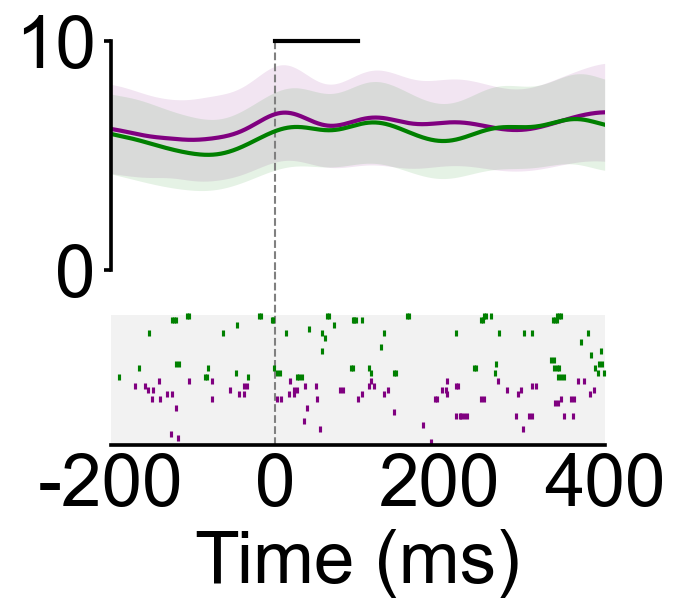

In [11]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    limitToUse = None#30
    
    # skip = True
    # if session == 'BS_40_2_AC.pickle' and clust in [190]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_3_AC.pickle' and clust in [15]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_6_AC.pickle' and clust in [27]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_10_AC.pickle' and clust in [55]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_15_AC.pickle' and clust in [0]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_40_16_AC.pickle' and clust in [24]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_5_AC.pickle' and clust in [2]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_8_AC.pickle' and clust in [15]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_9_AC.pickle' and clust in [37]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_11_AC.pickle' and clust in [18]:
    #     pass#Removed this day from consideration
    # if session == 'BS_42_2_AC.pickle' and clust in [62]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_42_3_AC.pickle' and clust in [63]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_42_7_AC.pickle' and clust in [100]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_42_11_AC.pickle' and clust in [44]:
    #     limitToUse = 40
    #     skip = False
    # if session == 'BS_49_1_AC.pickle' and clust in [23,143,150]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_49_2_AC.pickle' and clust in [6]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_49_4_AC.pickle' and clust in [27,68]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_49_4_AC.pickle' and clust in [39]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_49_9_AC.pickle' and clust in [45]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_50_7_AC.pickle' and clust in [12]:
    #     limitToUse = 40
    #     skip = False
    # if session == 'BS_70_7_AC.pickle' and clust in [63]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_70_8_AC.pickle' and clust in [3]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_72_7_AC.pickle' and clust in [35]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_87_1_AC.pickle' and clust in [30]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'BS_87_4_AC.pickle' and clust in [3]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_108_1_AC.pickle' and clust in [9]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'DS_15_1_AC.pickle' and clust in [16,59]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'DS_15_12_AC.pickle' and clust in [19]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_15_13_AC.pickle' and clust in [41]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_15_15_AC.pickle' and clust in [113]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_19_1_AC.pickle' and clust in [1]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'BS_40_2_AC.pickle' and clust in [210]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_42_7_AC.pickle' and clust in [124]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_15_16_AC.pickle' and clust in [23]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_19_14_AC.pickle' and clust in [19]:
    #     limitToUse = 30
    #     skip = False
    # if skip:
    #     continue

    try:
        plt.close('all')
        sessionfile = ilep.loadSessionCached(act_directory,session)
        if sessionfile.meta.task == 'switch':
            print("Skipping Switch")
            continue
        
    #     fig = plt.figure(figsize=(2.75,4.5))#Old Style
        fig = plt.figure(figsize=(4.25,3.5))#New Style
        gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)#Old hspace 0.125 #Old ratios [2,1]
        
        ax3 = plt.subplot(gs[1,0])#Raster
        ax4 = plt.subplot(gs[0,0])#,sharex=ax3)#PSTH
        ax3.set_facecolor('#F2F2F2')
        
        #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
        
    #     fst=-200
    #     fet=400
    #     xt=[-200,0,200,400]
        fst=-200
        fet=400
        xt=[-200,0,200,400]
        xtl=None#['-200','0','200','400']
        success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
        if not success:
            print('Fail')
            continue
        
        #Determine FRmod category
        FRmodCategory = 'ERROR'
        try:
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
            if FRmod < 3.5:
                FRmodCategory = 'NCR'
            elif FRmod > 5:
                FRmodCategory = 'CR'
            else:
                FRmodCategory = 'Middle'
        except Exception as e:
            print(e)
            pass
        #Skip unidentified category neurons
        if FRmodCategory in ['ERROR','nan',np.nan]:
            print("FRmodFail Skipping")
            continue
        region = sessionfile.meta.region
        EIL = EILphases[idx]
        #Skip unidentified phase neurons
        if EIL in ['ERROR','nan',np.nan]:
            print("PhaseFail Skipping")
            continue
           
        try:
            if not FRmodCategory == 'ERROR':
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','HitMissRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        except Exception as e:
            print(e)

    except:
        print('fail')

## Stim Rasters - Pre-Switch

0it [00:00, ?it/s]

BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19 Done
CR
switch


11it [00:01,  8.36it/s]

BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44 Done
Middle
switch


13it [00:02,  4.12it/s]

BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131 Done
CR
switch


19it [00:16,  1.21s/it]

BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22 Done
Middle
switch


104it [00:17,  7.80it/s]

BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33 Done
CR
switch


1829it [00:18, 96.30it/s]


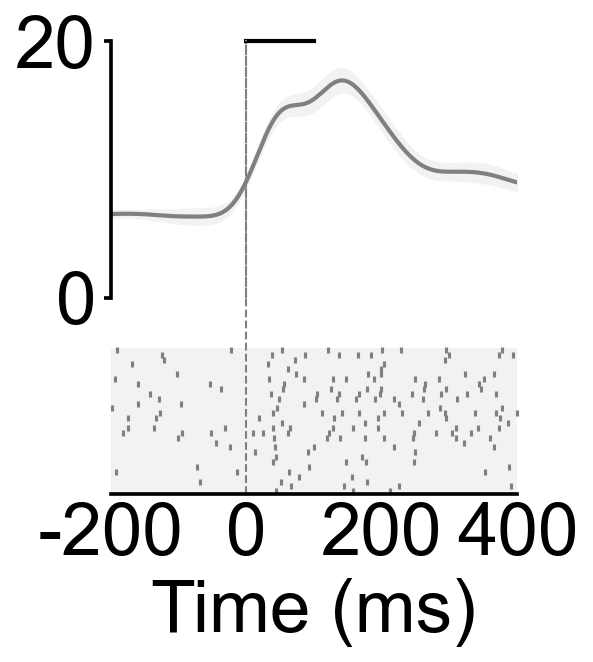

In [94]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    
    limitToUse = 20
    skip = True
    if session == 'BS_40_14_AC.pickle' and clust in [22]:
        skip = False
    if session == 'BS_41_1_AC.pickle' and clust in [33]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [44]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [131]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [19]:
        limitToUse = 40
        skip = False
    if skip:
        continue
        
    print(f"{session} clust {clust}")
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
        
    print(f"{session} clust {clust}")
    
#     fig = plt.figure(figsize=(2.75,4.5))
    fig = plt.figure(figsize=(3.5,4))
    gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)#,wspace=0.5)#0.1)
    
    ax4 = plt.subplot(gs[0,0],sharex=ax3)#PSTH
    ax3 = plt.subplot(gs[1,0])#Raster
    ax3.set_facecolor('#F2F2F2')
    
    print(f"{session} clust {clust}")
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    fst=-200
    fet=400
    xt=[-200,0,200,400]
    xtl=None#['-200','0','+200','+400']
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,switch_cond='pre_switch',limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
    if not success:
        continue
        
    print(f"{session} clust {clust}")
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['pre_switch'].FRmodulation
        if FRmod < 1:
            FRmodCategory = 'NCR'
        elif FRmod > 4.5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    print(f"{session} clust {clust} Done")
    print(FRmodCategory)
    print(EIL)
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

## Stim Rasters - Post-Switch

0it [00:00, ?it/s]

BS_108_3_AC.pickle clust 19


11it [00:01, 10.04it/s]

BS_108_3_AC.pickle clust 44


13it [00:02,  5.02it/s]

BS_108_3_AC.pickle clust 131


19it [00:03,  5.06it/s]

BS_40_14_AC.pickle clust 22


104it [00:04, 31.15it/s]

BS_41_1_AC.pickle clust 33


1829it [00:05, 313.49it/s]


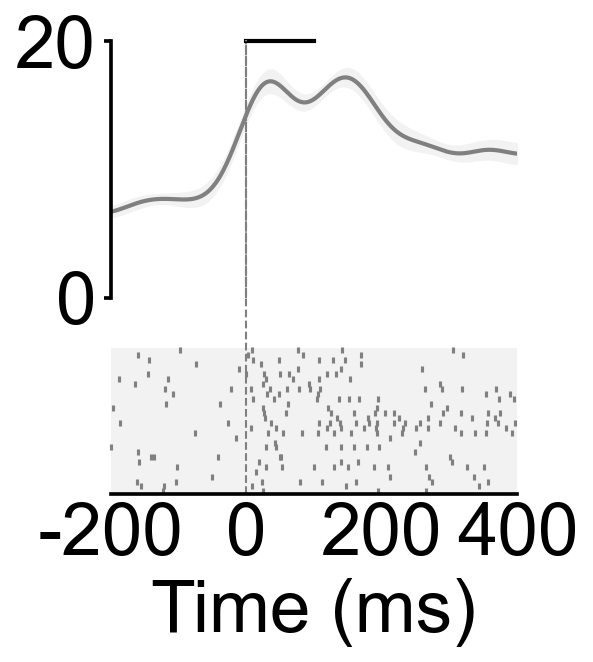

In [95]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    
    limitToUse = 20
    skip = True
    if session == 'BS_40_14_AC.pickle' and clust in [22]:
        skip = False
    if session == 'BS_41_1_AC.pickle' and clust in [33]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [44]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [131]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [19]:
        limitToUse = 40
        skip = False
    if skip:
        continue
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
    
#     fig = plt.figure(figsize=(2.75,4.5))
    fig = plt.figure(figsize=(3.5,4))
    gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)
    
    ax4 = plt.subplot(gs[0,0],sharex=ax3)#PSTH
    ax3 = plt.subplot(gs[1,0])#Raster
    ax3.set_facecolor('#F2F2F2')
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    fst=-200
    fet=400
    xt=[-200,0,200,400]
    xtl=None#['-200','0','200','400']
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,switch_cond='post_switch',limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['post_switch'].FRmodulation
        if FRmod < 1:
            FRmodCategory = 'NCR'
        elif FRmod > 4.5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    print(f"{session} clust {clust}")
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

# Choice Rasters

1829it [00:38, 47.39it/s] 


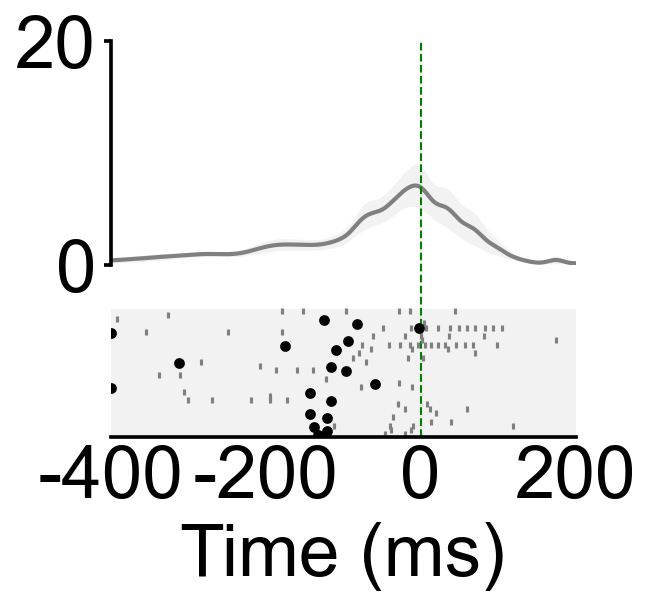

In [99]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):

    limitToUse = 20
    skip = True
    if session == 'BS_40_2_AC.pickle' and clust in [96,166,194,206,213]:
        if clust == 194:
            limitToUse = 40
        if clust == 96:
            limitToUse = 40
        if clust == 206:
            limitToUse = 40
        skip = False
    if session == 'BS_40_12_AC.pickle' and clust in [57]:
        limitToUse=30
        skip = False
    if session == 'BS_40_22_AC.pickle' and clust in [13]:
        skip = False
    if session == 'BS_41_9_AC.pickle' and clust in [37]:
        skip = False
    if session == 'BS_42_2_AC.pickle' and clust in [118]:
        skip = False
    if session == 'BS_42_4_AC.pickle' and clust in [65]:
        skip = False
    if session == 'BS_42_6_AC.pickle' and clust in [51]:
        limitToUse = 50
        skip = False
    if session == 'BS_42_9_AC.pickle' and clust in [32]:
        skip = False
    if session == 'BS_49_1_AC.pickle' and clust in [82,150]:
        skip = False
    if session == 'BS_49_9_AC.pickle' and clust in [61]:
        skip = False
    if session == 'BS_49_12_AC.pickle' and clust in [39]:
        skip = False
    if session == 'BS_50_2_AC.pickle' and clust in [14]:
        limitToUse = 40
        skip = False
    if session == 'BS_50_3_AC.pickle' and clust in [3]:
        limitToUse = 40
        skip = False
    if session == 'BS_50_3_AC.pickle' and clust in [16]:
        skip = False
    if session == 'BS_56_4_AC.pickle' and clust in [6]:
        skip = False
    if session == 'BS_50_7_AC.pickle' and clust in [5]:
        skip = False
    if session == 'BS_70_8_AC.pickle' and clust in [3]:
        skip = False
    if session == 'BS_72_1_AC.pickle' and clust in [24,30]:
        skip = False
    if session == 'BS_72_2_AC.pickle' and clust in [7,17]:
        if clust == 7:
            limitToUse = 30
        skip = False
    if session == 'BS_72_4_AC.pickle' and clust in [7,43]:
        skip = False
    if session == 'BS_72_5_AC.pickle' and clust in [22]:
        limitToUse = 50
        skip = False
    if session == 'BS_72_6_AC.pickle' and clust in [23]:
        skip = False
    if session == 'BS_87_4_AC.pickle' and clust in [154]:
        skip = False
    if session == 'BS_87_8_AC.pickle' and clust in [1]:
        skip = False
    if session == 'BS_108_1_AC.pickle' and clust in [9]:
        limitToUse=30
        skip = False
    if session == 'BS_108_6_AC.pickle' and clust in [126]:
        skip = False
    if session == 'DS_15_12_AC.pickle' and clust in [48]:
        limitToUse = 50
        skip = False
    if session == 'DS_15_13_AC.pickle' and clust in [84,113]:
        skip = False
    if session == 'DS_15_14_AC.pickle' and clust in [54]:
        skip = False
    if session == 'DS_19_3_AC.pickle' and clust in [115]:
        skip = False
    if skip:
        continue
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task == 'switch':
        continue
    
    fig = plt.figure(figsize=(4,3.5))
    gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)
    
    ax4 = plt.subplot(gs[0,0],sharex=ax3)#PSTH
    ax3 = plt.subplot(gs[1,0])#Raster
    ax3.set_facecolor('#F2F2F2')
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    
    fst=-400
    fet=200
    xt=[-400,-200,0,200]
    xtl=None#['-400','-200','0','+200']
    try:
        success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,align_to_choice=True,limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
    except Exception as e:
        print(e)
        success = False
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
        if FRmod < 0.8:
            FRmodCategory = 'NCR'
        elif FRmod > 4:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

## Choice Rasters - Pre-Switch

In [ ]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
    
#     fig = plt.figure(figsize=(3,6))
    fig = plt.figure(figsize=(2.75,4.5))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.125)#,wspace=0.5)#0.1)
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,Figure_start_time_ms=-750,Figure_end_time_ms=250,xtickstouse=[-1.0,-0.5,0],align_to_choice=True,switch_cond='pre_switch')
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
        if FRmod < 0.8:
            FRmodCategory = 'NCR'
        elif FRmod > 4:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

## Choice Rasters - Post-Switch

In [ ]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):

    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
    
#     fig = plt.figure(figsize=(3,6))
    fig = plt.figure(figsize=(2.75,4.5))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.125)#,wspace=0.5)#0.1)
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,Figure_start_time_ms=-750,Figure_end_time_ms=250,xtickstouse=[-1.0,-0.5,0],align_to_choice=True,switch_cond='post_switch')
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
        if FRmod < 0.8:
            FRmodCategory = 'NCR'
        elif FRmod > 4:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

# Combined Rasters

In [ ]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    limitToUse = None#30
    
#     skip = True
#     if session == 'BS_40_2_AC.pickle' and clust in [190]:
#         limitToUse = 20
#         skip = False
#     if skip:
#         continue
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task == 'switch':
        print("Skipping Switch")
        continue
    
    fig = plt.figure(figsize=(10,6.25))#New Style
    gs = fig.add_gridspec(2,2,height_ratios=[1,1],wspace=0.75,hspace=0.25)#Old hspace 0.125 #Old ratios [2,1]
    #Stim
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    #Choice
    cax3 = plt.subplot(gs[0,1])#Raster
    cax4 = plt.subplot(gs[1,1],sharex=cax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    try:
        stim_success,stim_artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,limitToUse=limitToUse,Figure_start_time_ms=-50,Figure_end_time_ms=150,xtickstouse=[-50,0,50,100,150])
    except:
        stim_success = False
    if not stim_success:
        continue
    try:
        choice_success,choice_artists = visualizeClusterChoiceInternal(sessionfile,clust,cax3,cax4,limitToUse=limitToUse,align_to_choice=True,Figure_start_time_ms=-150,Figure_end_time_ms=50,xtickstouse=[-150,-100,-50,0,50])
    except:
        choice_success = False
    if not choice_success:
        continue
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    Choicemod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
    
    ttl1 = ax3.set_title(FRmod)
    ttl2 = cax3.set_title(Choicemod)
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        if FRmod < 3.5:
            FRmodCategory = 'NCR'
        elif FRmod > 5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        print("FRmodFail Skipping")
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        print("PhaseFail Skipping")
        continue
        
#     break
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

16it [01:10,  1.55s/it]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


22it [01:10,  1.59it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


28it [01:10,  3.30it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


34it [01:11,  5.67it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


37it [01:11,  7.38it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


40it [01:11,  9.24it/s]

Skipping Switch
Skipping Switch


105it [15:30,  1.32it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


113it [15:30,  3.89it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


121it [15:30,  7.99it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


124it [15:30,  9.96it/s]

Skipping Switch


302it [1:01:39, 12.78s/it]

PhaseFail Skipping


303it [1:01:41,  9.72s/it]

PhaseFail Skipping


304it [1:01:50,  9.39s/it]

PhaseFail Skipping


305it [1:01:54,  7.70s/it]

PhaseFail Skipping


306it [1:01:56,  6.20s/it]

PhaseFail Skipping


307it [1:01:59,  5.15s/it]

PhaseFail Skipping


308it [1:02:01,  4.37s/it]

PhaseFail Skipping


309it [1:02:06,  4.32s/it]

PhaseFail Skipping


310it [1:02:08,  3.80s/it]

PhaseFail Skipping


311it [1:02:11,  3.37s/it]

PhaseFail Skipping


312it [1:02:14,  3.23s/it]

PhaseFail Skipping


313it [1:02:16,  3.02s/it]

PhaseFail Skipping


314it [1:02:17,  2.37s/it]

PhaseFail Skipping


315it [1:02:19,  2.37s/it]

PhaseFail Skipping


316it [1:02:22,  2.51s/it]

PhaseFail Skipping


319it [1:02:25,  1.45s/it]

PhaseFail Skipping
Skipping Switch
Skipping Switch
Skipping Switch


323it [1:02:25,  1.68it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


327it [1:02:26,  3.33it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


331it [1:02:26,  5.68it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


335it [1:02:26,  8.48it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


339it [1:02:27, 11.13it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


343it [1:02:27, 12.84it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


347it [1:02:27, 14.36it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


351it [1:02:27, 15.02it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


355it [1:02:28, 15.11it/s]

Skipping Switch
Skipping Switch
Skipping Switch


477it [1:42:23,  1.60s/it]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


485it [1:42:24,  1.60it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


646it [2:50:03, 26.25s/it]

In [35]:
A

[[0, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 8],
 [7, 8, 9],
 [8, 9, 10],
 [9, 10, 11]]

In [34]:
A = [ [a,a+1,a+2] for a in range(10)]

In [36]:
kf = KFold(n_splits=10)
for idx,(_,train_index) in enumerate(kf.split(A)):
    print(train_index)
    print(A[train_index])

[0]


TypeError: only integer scalar arrays can be converted to a scalar index